In [1]:
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
robo_flags=pd.read_csv('/nobackup/khauskne/kdd/robovetter_flags_all_DR25.csv')

In [3]:
def apply_statistics(branches, files, num_PCs):
    new_csv=files[0].copy()
    new_csv.pop('Unnamed: 0')
    for branch in branches:
        all_scores=np.zeros(tuple((num_PCs, np.shape(files[0])[0])))
        for example in range(len(files)):
            all_scores[example]=files[example][branch]
        col_index=new_csv.columns.get_loc(branch)
        new_csv[branch]=np.mean(all_scores, axis=0)
        new_csv.insert(col_index+1, branch+' Std', np.std(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Max', np.max(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Min', np.min(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Med', np.median(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Mean+Std', np.mean(all_scores, axis=0)+np.std(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Mean-Std', np.mean(all_scores, axis=0)-np.std(all_scores, axis=0))
    return new_csv



def evaluate_mean(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]]<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'], 'minor_flags':csv['Minor_Descriptive_Flags'],'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_min(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Min']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_max(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Max']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_med(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Med']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict


In [4]:
def summary_statistics(stat_func, num_PCs, trials):
    train=[]
    val=[]
    test=[]
    for trial in range(1, trials+1):
        run='/nobackup/khauskne/kdd/explainability_runs/exp_'+str(num_PCs)+'_PCs_trial_'+str(trial)+'/'
        #print(run)
        all_train_groups=[]
        for index in range(num_PCs):
            train_group=pd.read_csv(run+'train_top_'+str(index)+'.csv')
            all_train_groups.append(train_group)
    

        all_val_groups=[]
        for index in range(num_PCs):
            val_group=pd.read_csv(run+'val_top_'+str(index)+'.csv')
            all_val_groups.append(val_group)

        all_test_groups=[]
        for index in range(num_PCs):
            test_group=pd.read_csv(run+'test_top_'+str(index)+'.csv')
            all_test_groups.append(test_group)

        branches=['Global Flux', 'Local Flux', 'Centroid', 'Odd Even', 'Secondary', 'Stellar', 'DV']
        train_statistics=apply_statistics(branches, all_train_groups, num_PCs)
        val_statistics=apply_statistics(branches, all_val_groups, num_PCs)
        test_statistics=apply_statistics(branches, all_test_groups, num_PCs)
        
        train.append(stat_func(train_statistics, branches))
        val.append(stat_func(val_statistics, branches))
        test.append(stat_func(test_statistics, branches))

    return train, val, test

In [5]:
stats=summary_statistics(evaluate_min, 15, 10)

In [6]:
def post_process_flags(robo_flags, branch_explanations):
    branch_inds_to_keep=[1,2,3,4,6]
    
    robo_new=np.moveaxis(robo_flags,0, -1)[branch_inds_to_keep]
    robo_new=np.moveaxis(robo_new, 0, -1)
    
    exp_new=np.moveaxis(branch_explanations, 0, -1)
    global_flux=exp_new[0]
    local_flux=exp_new[1]
   # print(np.shape(global_flux))
    #added_flux=exp_new[0]+exp_new[1]
    #combined_flux=np.where(added_flux>0, 1, 0)
    greater_flux=np.amin([global_flux, local_flux], axis=0)
   # print(greater_flux)
    exp_new=exp_new[branch_inds_to_keep]
    exp_new[0]=greater_flux
    exp_new=np.moveaxis(exp_new, 0, -1)
    
    return robo_new, exp_new

In [7]:
def top_n(robo_array, occlusion_array, n, average_type='weighted'):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[:n]
        #print(max_contrib)
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
        #print(occlusion[index])
    weighted_prec=precision_score(robo, occlusion, average=average_type, zero_division=0)
    weighted_rec=recall_score(robo,occlusion, average=average_type, zero_division=0)
    return weighted_prec, weighted_rec

In [8]:
def top_n_hamming(robo_array, occlusion_array, n):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[:n]
        #print(max_contrib)
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
        #print(occlusion[index])
    weighted_prec=hamming_loss(robo, occlusion)
    #weighted_rec=recall_score(robo,occlusion, average=average_type)
    return weighted_prec#, weighted_rec

In [9]:
def top_n_acc(robo_array, occlusion_array, n):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[:n]
        #print(max_contrib)
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
        #print(occlusion[index])
    weighted_prec=accuracy_score(robo, occlusion)
    #weighted_rec=recall_score(robo,occlusion, average=average_type)
    return weighted_prec#, weighted_rec

In [10]:
def top_n_jaccard(robo_array, occlusion_array, n, average_type='weighted'):
    robo, occlusion=post_process_flags(robo_array, occlusion_array)
    for index in range(len(occlusion)):
        tce=occlusion[index]
        max_contrib=np.argsort(tce)[:n]
        #print(max_contrib)
        occlusion[index]=np.zeros([5])
        occlusion[index][max_contrib]=1
        #print(occlusion[index])
    weighted_prec=jaccard_score(robo, occlusion, average=average_type)
    #weighted_rec=recall_score(robo,occlusion, average=average_type)
    return weighted_prec#, weighted_rec

In [14]:
def metrics_loop(n):
    micro_prec=[]
    micro_rec=[]
    macro_prec=[]
    macro_rec=[]    
    weighted_prec=[]
    weighted_rec=[]
    hamming=[]
    acc=[]
    jaccard=[]
    for i in range(10):
        robo_test=stats[2][i]['robo_flags']
        exp_test=stats[2][i]['branch_explanations']
        micro=top_n(robo_test, exp_test,n,'micro')
        micro_prec.append(micro[0])
        micro_rec.append(micro[1])
        macro=top_n(robo_test, exp_test,n,'macro')
        macro_prec.append(macro[0])
        macro_rec.append(macro[1])
        weighted=top_n(robo_test, exp_test,n,'weighted')
        weighted_prec.append(weighted[0])
        weighted_rec.append(weighted[1])
        hamming.append(top_n_hamming(robo_test,exp_test,n))
        acc.append(top_n_acc(robo_test, exp_test,n))
        jaccard.append(top_n_jaccard(robo_test,exp_test, n))
    return np.mean(micro_prec), np.mean(micro_rec), np.mean(macro_prec), np.mean(macro_rec), np.mean(weighted_prec), np.mean(weighted_rec), np.mean(hamming), np.mean(acc), np.mean(jaccard)

In [16]:
top_1=metrics_loop(1)

In [19]:
np.round(top_1, 4)

array([0.5405, 0.5456, 0.3176, 0.341 , 0.65  , 0.5456, 0.1819, 0.4247,
       0.435 ])

In [20]:
np.round(metrics_loop(2),4)

array([0.3865, 0.7804, 0.2781, 0.5224, 0.5941, 0.7804, 0.2889, 0.0307,
       0.5354])

In [21]:
np.round(metrics_loop(3),4)

array([0.3001, 0.9088, 0.2416, 0.7074, 0.5512, 0.9088, 0.438 , 0.0064,
       0.536 ])

In [68]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [55]:
robo_test=stats[2][5]['robo_flags']
exp_test=stats[2][5]['branch_explanations']

In [56]:
top_n(robo_test, exp_test,1)

(0.6614493843824216, 0.520435069215557)

In [58]:
top_n(robo_test, exp_test,1, 'micro')

(0.515507672216781, 0.520435069215557)

In [59]:
top_n(robo_test, exp_test,1, 'macro')

(0.31880208871194926, 0.3361745358255953)

In [57]:
top_n(robo_test, exp_test,2)

(0.6037155309820135, 0.7762030323005933)

## Loop

In [11]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

In [40]:
def eval_jaccard(stat_func, num_pcs, trials, average_type='weighted'):
    stats=summary_statistics(stat_func, num_pcs,trials)
    
    precision_list=[]
    recall_list=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        
        scores=post_process_flags(test_robo, test_exp)
        weighted_prec=jaccard_score(scores[0], scores[1], average=average_type)
        #weighted_rec=recall_score(scores[0], scores[1], average=average_type)
        precision_list.append(weighted_prec)
        #recall_list.append(weighted_rec)
        
    return np.mean(precision_list), np.std(precision_list)#, np.mean(recall_list), np.std(recall_list)
        

In [41]:
eval_jaccard(evaluate_min, 15, 10)

(0.6071058307411425, 0.004595509247011755)

In [42]:
def eval_acc(stat_func, num_pcs, trials):
    stats=summary_statistics(stat_func, num_pcs,trials)
    
    precision_list=[]
    recall_list=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        
        scores=post_process_flags(test_robo, test_exp)
        weighted_prec=accuracy_score(scores[0], scores[1])
        #weighted_rec=recall_score(scores[0], scores[1], average=average_type)
        precision_list.append(weighted_prec)
        #recall_list.append(weighted_rec)
        
    return np.mean(precision_list), np.std(precision_list)#, np.mean(recall_list), np.std(recall_list)
        

In [45]:
eval_acc(evaluate_min, 15, 10)

(0.1632386549134835, 0.015574712899907084)

In [47]:
def eval_hamming(stat_func, num_pcs, trials):
    stats=summary_statistics(stat_func, num_pcs,trials)
    
    precision_list=[]
    recall_list=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        
        scores=post_process_flags(test_robo, test_exp)
        weighted_prec=hamming_loss(scores[0], scores[1])
        #weighted_rec=recall_score(scores[0], scores[1], average=average_type)
        precision_list.append(weighted_prec)
        #recall_list.append(weighted_rec)
        
    return np.mean(precision_list), np.std(precision_list)

In [48]:
eval_hamming(evaluate_min, 15, 10)

(0.3208488410055501, 0.017004016489277678)

Text(0.5, 1.0, 'Micro Precision and Recall for Top n labeled with Occlusion')

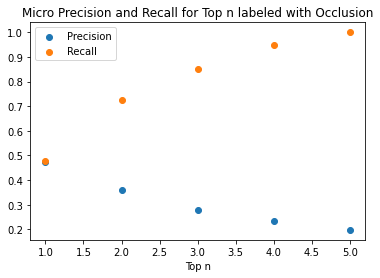

In [33]:
plt.scatter(np.arange(1,6), prec_vals, label='Precision')
plt.scatter(np.arange(1,6), rec_vals, label='Recall')
plt.legend()
plt.xlabel('Top n')
plt.title('Micro Precision and Recall for Top n labeled with Occlusion')

In [11]:
def eval_weighted_metrics(stat_func, num_pcs, trials, average_type='weighted'):
    stats=summary_statistics(stat_func, num_pcs,trials)
    
    precision_list=[]
    recall_list=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        
        scores=post_process_flags(test_robo, test_exp)
        weighted_prec=precision_score(scores[0], scores[1], average=average_type)
        weighted_rec=recall_score(scores[0], scores[1], average=average_type)
        precision_list.append(weighted_prec)
        recall_list.append(weighted_rec)
        
    return np.mean(precision_list), np.std(precision_list), np.mean(recall_list), np.std(recall_list)
        
    

In [27]:
eval_weighted_metrics(evaluate_min, 15, 10, 'micro')

(0.37073388742158797,
 0.012440694861750186,
 0.8837837837837839,
 0.00987826378110965)

In [28]:
eval_weighted_metrics(evaluate_min, 15, 10, 'macro')

(0.2878941480122471,
 0.0122323037374948,
 0.656210469741655,
 0.020502829569494337)

In [29]:
eval_weighted_metrics(evaluate_min, 15, 10, 'weighted')

(0.6322190998781286,
 0.009061035361970586,
 0.8837837837837839,
 0.00987826378110965)

In [20]:
prec_vals=[]
prec_vals_std=[]
rec_vals=[]
rec_vals_std=[]
for i in range(1,15):
    vals=eval_weighted_metrics(evaluate_min, i, 10)
    prec_vals.append(vals[0])
    prec_vals_std.append(vals[1])
    rec_vals.append(vals[2])
    rec_vals_std.append(vals[3])
    print(vals[0])
    print(vals[2])

0.6914361457363418
0.7648648648648648
0.6823358207003833
0.7767303889255108
0.6739085814518725
0.7998352010547133
0.6775304477251631
0.7992748846407383
0.6589163905248137
0.8352999340804217
0.6642665692164897
0.8293012524719842
0.6523468803830351
0.8563612392880685
0.6544627931175311
0.8520105471324984
0.6463386628671931
0.86430454845089
0.6414684250369782
0.872874093605801
0.649133026763153
0.8624917600527355
0.6416260217316718
0.8718852999340804
0.6573194966990561
0.8457811470006593
0.6520411646776982
0.860744891232696


Text(0.5, 0, 'Number of PCs')

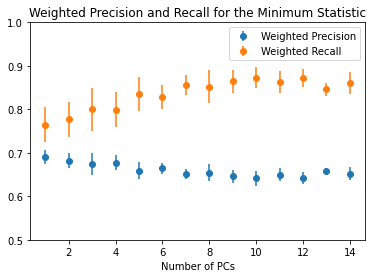

In [23]:
plt.errorbar(np.arange(1, 15), prec_vals, prec_vals_std, fmt='o', label='Weighted Precision')
plt.errorbar(np.arange(1, 15), rec_vals, rec_vals_std, fmt='o', label='Weighted Recall')
plt.ylim([0.5, 1])
plt.legend()
plt.title('Weighted Precision and Recall for the Minimum Statistic')
plt.xlabel('Number of PCs')

In [24]:
prec_vals_mean=[]
prec_vals_std_mean=[]
rec_vals_mean=[]
rec_vals_std_mean=[]
for i in range(1,15):
    vals=eval_weighted_metrics(evaluate_mean, i, 10)
    prec_vals_mean.append(vals[0])
    prec_vals_std_mean.append(vals[1])
    rec_vals_mean.append(vals[2])
    rec_vals_std_mean.append(vals[3])
    print(vals[0])
    print(vals[2])

0.6914361457363418
0.7648648648648648
0.6998123314196992
0.734838497033619
0.704380275201921
0.734377059986816
0.7034886123904975
0.7337837837837837
0.7025187611662151
0.7362228081740277
0.7043089044030836
0.7342122610415294
0.6994183794811865
0.7448912326961107
0.7043634725307653
0.7344759393539882
0.7018664947342482
0.740870138431114
0.6993940788069164
0.7442979564930785
0.7011568638023479
0.7393210283454186
0.6997470206799836
0.7429136453526698
0.7079035434006837
0.7210283454185893
0.7052881699117487
0.7254779169413315


Text(0.5, 0, 'Number of PCs')

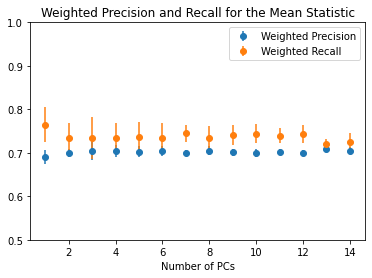

In [25]:
plt.errorbar(np.arange(1, 15), prec_vals_mean, prec_vals_std_mean, fmt='o', label='Weighted Precision')
plt.errorbar(np.arange(1, 15), rec_vals_mean, rec_vals_std_mean, fmt='o', label='Weighted Recall')
plt.ylim([0.5, 1])
plt.legend()
plt.title('Weighted Precision and Recall for the Mean Statistic')
plt.xlabel('Number of PCs')

In [18]:
precision_score(scores[0], scores[1], average='macro')

0.27614933540189074

In [14]:
prec_vals_micro=[]
prec_vals_std_micro=[]
rec_vals_micro=[]
rec_vals_std_micro=[]
for i in range(1,15):
    vals=eval_weighted_metrics(evaluate_min, i, 10, average_type='macro')
    prec_vals_micro.append(vals[0])
    prec_vals_std_micro.append(vals[1])
    rec_vals_micro.append(vals[2])
    rec_vals_std_micro.append(vals[3])
    print(vals[0])
    print(vals[2])

0.3438930545038723
0.5326448740386679
0.3331627617201214
0.5556952513560893
0.32825827742709385
0.5642998595583089
0.32752495826365646
0.572632353322183
0.3131478012585049
0.6047652950777751
0.3155076961783013
0.6101187964424084
0.3064775856863642
0.6318879349682265
0.31633564533786374
0.6175501617994267
0.30538352839712457
0.6327764354338316
0.29368299432328915
0.6519198890364836
0.3052081256415134
0.6360308718161021
0.29029654736716715
0.651474119672746
0.31092775078998935
0.61910589304962
0.3013403275624606
0.6481680329645114


Text(0.5, 0, 'Number of PCs')

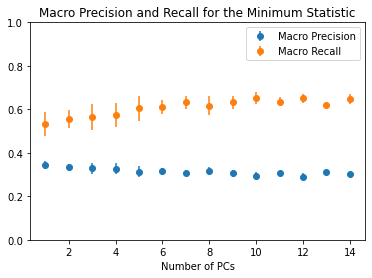

In [16]:
plt.errorbar(np.arange(1, 15), prec_vals_micro, prec_vals_std_micro, fmt='o', label='Macro Precision')
plt.errorbar(np.arange(1, 15), rec_vals_micro, rec_vals_std_micro, fmt='o', label='Macro Recall')
plt.ylim([0, 1])
plt.legend()
plt.title('Macro Precision and Recall for the Minimum Statistic')
plt.xlabel('Number of PCs')

In [48]:
np.sum(robo_flags['Centroid Flag'].iloc[np.where(robo_flags['Not_Transit-Like_Flag']==1)])

1452

In [49]:
np.sum(robo_flags['Secondary Flag'].iloc[np.where(robo_flags['Not_Transit-Like_Flag']==1)])

1136

In [50]:
np.sum(robo_flags['Odd Even Flag'].iloc[np.where(robo_flags['Not_Transit-Like_Flag']==1)])

0

In [61]:
np.array(robo_flags.iloc[np.where(robo_flags['Not_Transit-Like_Flag']==1)][33:34]['Minor_Descriptive_Flags'])

array(['LPP_DV---LPP_ALT---MOD_NONUNIQ_DV---MOD_NONUNIQ_ALT---CENT_RESOLVED_OFFSET'],
      dtype=object)

In [7]:
def eval_branch(stat_func, num_pcs, trials,branch_ind):
    stats=summary_statistics(stat_func, num_pcs,trials)
    
    precision_list=[]
    recall_list=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        
        scores=post_process_flags(test_robo, test_exp)
        true=np.moveaxis(scores[0], 0, -1)[branch_ind]    
        pred=np.moveaxis(scores[1], 0, -1)[branch_ind]
        prec=precision_score(true, pred)
        rec=recall_score(true, pred)
        precision_list.append(prec)
        recall_list.append(rec)
        
    return np.mean(precision_list), np.std(precision_list), np.mean(recall_list), np.std(recall_list)

In [11]:
eval_branch(evaluate_min, 15, 10, 0)

(0.8191767103967671,
 0.010625133857475592,
 0.9570557899671824,
 0.013763296565654079)

In [20]:
eval_branch(evaluate_min, 15, 10, 1)

(0.35918196835178573,
 0.05508055252226271,
 0.7665399239543726,
 0.023939279450490025)

In [13]:
eval_branch(evaluate_min, 15, 10, 2)

(0.0030115842238315725, 0.0002617315043909363, 0.03333333333333333, 0.0)

In [23]:
eval_branch(evaluate_min, 15, 10, 3)

(0.10385906439894468,
 0.003425237810001112,
 0.82568093385214,
 0.010265296465582054)

In [15]:
eval_branch(evaluate_min, 15, 10, 4)

(0.15424141268990627,
 0.005524624959212785,
 0.6984423676012461,
 0.1026317829328936)

In [12]:
def eval_PCs(stat_func, num_pcs, trials):
    stats=summary_statistics(stat_func, num_pcs,trials)
    precision_list=[]
    recall_list=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        label=np.zeros(3063)
        label[np.where(stats[2][i]['original_label']=='PC')]=1
        
        
        scores=post_process_flags(test_robo, test_exp)
        sum_scores=np.sum(scores[1], axis=1)
        sum_scores[np.where(sum_scores>0)]=-1
        sum_scores[np.where(sum_scores==0)]=1
        sum_scores[np.where(sum_scores==-1)]=0
        true=label   
        pred=sum_scores
        prec=precision_score(true, pred)
        rec=recall_score(true, pred)
        precision_list.append(prec)
        recall_list.append(rec)
        
    return np.mean(precision_list), np.std(precision_list), np.mean(recall_list), np.std(recall_list)

In [59]:
eval_PCs(evaluate_min, 15, 10)

(0.7087772929251324,
 0.07142571848974358,
 0.9615942028985508,
 0.015388956943185006)

In [60]:
np.shape(np.where(label==1))

(1, 276)

# Thresholding


In [14]:
def evaluate_min_thresh(csv, branches, threshold):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Min']<-1*threshold)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

In [15]:
def evaluate_mean_thresh(csv, branches, threshold):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Mean']<-1*threshold)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

In [16]:
def summary_threshold(num_PCs, trials):
   # train=[]
   # val=[]
    test=[]
    for trial in range(1, trials+1):
        run='/nobackup/khauskne/kdd/explainability_runs/exp_'+str(num_PCs)+'_PCs_trial_'+str(trial)+'/'
        #print(run)

        all_test_groups=[]
        for index in range(num_PCs):
            test_group=pd.read_csv(run+'test_top_'+str(index)+'.csv')
            all_test_groups.append(test_group)

        branches=['Global Flux', 'Local Flux', 'Centroid', 'Odd Even', 'Secondary', 'Stellar', 'DV']
       # train_statistics=apply_statistics(branches, all_train_groups, num_PCs)
        #val_statistics=apply_statistics(branches, all_val_groups, num_PCs)
        test_statistics=apply_statistics(branches, all_test_groups, num_PCs)
        
       # train.append(train_statistics)
        #val.append(val_statistics)
        test.append(test_statistics)

    return test

In [17]:
branches=['Global Flux', 'Local Flux', 'Centroid', 'Odd Even', 'Secondary', 'Stellar', 'DV']

In [22]:
def eval_thresh(num_PCs,trials):
    prec_arr=[]
    rec_arr=[]
    all_15=summary_threshold(num_PCs, trials)
    for threshold in np.linspace(0, 1, 200):
        precision_list=[]
        recall_list=[]
        for i in range(trials):
            trial_val=evaluate_min_thresh(all_15[i], branches, threshold)
            test_exp=trial_val['branch_explanations']
            test_robo=trial_val['robo_flags']

            scores=post_process_flags(test_robo, test_exp)
            weighted_prec=precision_score(scores[0], scores[1], average='weighted', zero_division=0)
            weighted_rec=recall_score(scores[0], scores[1], average='weighted', zero_division=0)
            precision_list.append(weighted_prec)
            recall_list.append(weighted_rec)
        prec_arr.append(np.mean(precision_list))
        rec_arr.append(np.mean(recall_list))
    return prec_arr, rec_arr


In [19]:
thresholding_1=eval_thresh(1, 10)
thresholding_5=eval_thresh(5, 10)
thresholding_10=eval_thresh(10, 10)
thresholding_15=eval_thresh(15, 10)

In [32]:
def eval_thresh_PC(num_PCs,trials):
    prec_arr=[]
    rec_arr=[]
    all_15=summary_threshold(num_PCs, trials)
    for threshold in np.linspace(0, 1, 200):
        precision_list=[]
        recall_list=[]
        for i in range(trials):
            trial_val=evaluate_min_thresh(all_15[i], branches, threshold)
            test_exp=trial_val['branch_explanations']
            test_robo=trial_val['robo_flags']
            label=np.zeros(3063)
            label[np.where(trial_val['original_label']=='PC')]=1

            scores=post_process_flags(test_robo, test_exp)
            sum_scores=np.sum(scores[1], axis=1)
            sum_scores[np.where(sum_scores>0)]=-1
            sum_scores[np.where(sum_scores==0)]=1
            sum_scores[np.where(sum_scores==-1)]=0
            true=label   
            pred=sum_scores
            prec=precision_score(true, pred, zero_division=0)
            rec=recall_score(true, pred, zero_division=0)
            precision_list.append(prec)
            recall_list.append(rec)
        prec_arr.append(np.mean(precision_list))
        rec_arr.append(np.mean(recall_list))
    return prec_arr, rec_arr

In [39]:
tested=eval_thresh_PC(15,10)

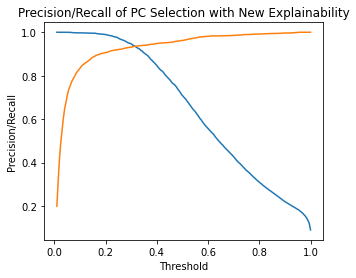

In [47]:
plt.figure(figsize(5,4))
plt.plot(np.linspace(0, 1, 200)[2:], tested[0][2:])
plt.plot(np.linspace(0, 1, 200)[2:], tested[1][2:])
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision/Recall of PC Selection with New Explainability')
plt.savefig('PC_selection_newexp.pdf')

In [45]:
np.save('/nobackup/khauskne/kdd/prec_thresh_PC_newexp.npy',[np.linspace(0, 1, 200)[2:], tested[0][:2]])
np.save('/nobackup/khauskne/kdd/rec_thresh_PC_newexp.npy',[np.linspace(0, 1, 200)[2:], tested[1][:2]])

/home4/khauskne/.conda/envs/ML_env/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'Recall of Classifier for Different Number of PCs')

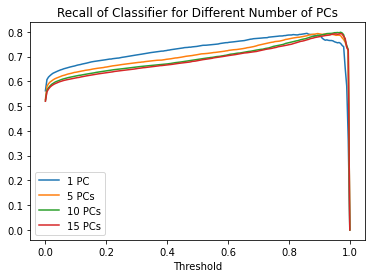

In [30]:
plt.plot(np.linspace(0, 1, 200), thresholding_1[0], label='1 PC')
plt.plot(np.linspace(0, 1, 200), thresholding_5[0], label='5 PCs')
#plt.plot(np.linspace(0, 1, 200), thresholding_1[1], label='Recall')
plt.plot(np.linspace(0, 1, 200), thresholding_10[0], label='10 PCs')
plt.plot(np.linspace(0, 1, 200), thresholding_15[0], label='15 PCs')
#plt.plot(np.linspace(0, 1, 200), thresholding_10[1], label='Recall')
plt.legend()
#plt.ylim([0, 1])
plt.xlabel('Threshold')
plt.title('Recall of Classifier for Different Number of PCs')

Text(0.5, 1.0, 'Weighted Precision and Recall vs. Threshold for Proposed Method')

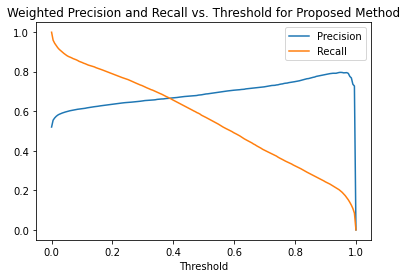

In [31]:
plt.plot(np.linspace(0, 1, 200), thresholding[0], label='Precision')
plt.plot(np.linspace(0, 1, 200), thresholding[1], label='Recall')
plt.legend()
#plt.ylim([0, 1])
plt.xlabel('Threshold')
plt.title('Weighted Precision and Recall vs. Threshold for Proposed Method')

In [32]:
np.save('/nobackup/khauskne/kdd/prec_thresh_new_exp.npy',[np.linspace(0, 1, 200), thresholding[0]])

In [33]:
np.save('/nobackup/khauskne/kdd/rec_thresh_new_exp.npy',[np.linspace(0, 1, 200), thresholding[1]])